# Ensemble methods for Pulsar Neutron Star Classification

As a former scientist I love pretty much everything in physics and astronomy has always interested me due to the extreme conditions being studied. Some of the most fascinating objects  found in space are Pulsars, a special kind of neutron stars. We can read in the description accompanying this data set: 

*"Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. \[...\] As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars
rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes."* 

This data set contains events of radio signal detection representing Pulsar candidates, which were recorded during the [High Time Resolution Universe Survey 1](https://academic.oup.com/mnras/article/409/2/619/1037409). It was contributed to the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/HTRU2#) by Robert Lyon from the University of Manchester's School of Physics and Astronomy.

## Frame the Problem

To detect the Pulsars, the signal is recorded over many rotations of the pulsar and the integrated pulse profile is used along with the DM-SNR curve (dispersion measure - signal to noise ratio curve, see [here](http://www.scienceguyrob.com/wp-content/uploads/2016/12/WhyArePulsarsHardToFind_Lyon_2016.pdf)).
However, Pulsars are very rare and many spurious events caused by radio frequency interference (RFI) get detected, which makes it hard to find legitimate signals. It is very time-intensive and costly to have every record checked by human experts, therefore, machine learning could be of great aid to Pulsar detection.

We have a two-class classification problem at hand (Pulsar or not Pulsar) and we are most likely dealing with a high class imbalance because Pulsars are very rare. Because of this imbalance, we should not choose accuracy as a metric to evaluate the performance of our model. It is probably not a catastrophe if human experts will still find some false positives which they have to filter out manually, but we'd be really sad if me miss a rare Pulsar (false negative). Hence, we should optimize for recall to minimize the false negative ratio.

In [1]:
# import libraries 
import numpy as np # numerical computation
import pandas as pd # data handling
import warnings
warnings.filterwarnings('ignore')
# visulalization
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("darkgrid")
%matplotlib notebook

## Data preparation
Let's import the data into data frame hand have a look.

In [2]:
# load data and show first 5 rows
# the columns are:
# 1. Mean of the integrated profile.
# 2. Standard deviation of the integrated profile.
# 3. Excess kurtosis of the integrated profile.
# 4. Skewness of the integrated profile.
# 5. Mean of the DM-SNR curve.
# 6. Standard deviation of the DM-SNR curve.
# 7. Excess kurtosis of the DM-SNR curve.
# 8. Skewness of the DM-SNR curve.
# 9. Class (1 = Pulsar, 0 = no Pulsar)

pulsar = pd.read_csv("HTRU_2.csv",header=None,names=["ip_mean","ip_std","ip_kurt","ip_skew","dmsnr_mean","dmsnr_std","dmsnr_kurt","dmsnr_skew","label"])
pulsar.head()

,ip_mean,ip_std,ip_kurt,ip_skew,dmsnr_mean,dmsnr_std,dmsnr_kurt,dmsnr_skew,label
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [3]:
# print info
pulsar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
ip_mean       17898 non-null float64
ip_std        17898 non-null float64
ip_kurt       17898 non-null float64
ip_skew       17898 non-null float64
dmsnr_mean    17898 non-null float64
dmsnr_std     17898 non-null float64
dmsnr_kurt    17898 non-null float64
dmsnr_skew    17898 non-null float64
label         17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [4]:
# print describtion 
pulsar.describe()

,ip_mean,ip_std,ip_kurt,ip_skew,dmsnr_mean,dmsnr_std,dmsnr_kurt,dmsnr_skew,label
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309331,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392140,110.642211,34.539844,1191.000837,1.000000


In [5]:
# look for missing values
pulsar.isna().sum()

ip_mean       0
ip_std        0
ip_kurt       0
ip_skew       0
dmsnr_mean    0
dmsnr_std     0
dmsnr_kurt    0
dmsnr_skew    0
label         0
dtype: int64

In [6]:
# look at class distribution
pulsar.label.value_counts()

0    16259
1     1639
Name: label, dtype: int64

We have 17898 instances of which only 9.2 % correspond to the positive class. The 8 numerical features correspond to simple statistics (mean, standard deviation, excess kurtosis, and skewness) of the radio signals' integrated profile and DM-SNR curve.

We can have a look on how the features are distributed by plotting them in histograms:

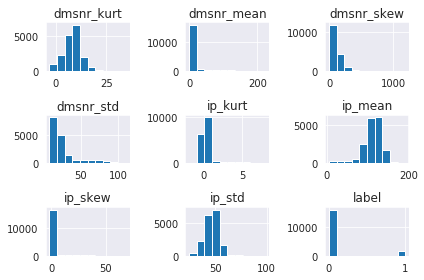

In [7]:
# plot histograms
pulsar.hist()
plt.tight_layout()

We can see a couple of things in these histograms: 
- It does not look like any of the features were clipped of at any maximum or minimum value (which is great so we won't have to fix that).
- The features are on very different scales, so we will have to rescale them later on.
- Some of the features are very skewed or have outliers, which can be a problem for some algorithms and scaling transformations. We could try to transform them into a more Gaussian shape.

We can now put aside a hold-out test set. Or actually, since I want to work with ensemble methods in this example, I will also split the train set into two subsets. One will be used to train and tune different classifiers and the second one will be used to train another classifier in a second layer which will blend the outputs of the first layer of classifiers. If we are lucky, our blended ensemble will work better than the individual classifiers.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
# put 20%  of the data aside as a test set
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_index, test_index in split1.split(pulsar, pulsar["label"]):
    pulsar_train = pulsar.loc[train_index]
    pulsar_test = pulsar.loc[test_index]
    X_test = pulsar_test.loc[:,"ip_mean":"dmsnr_skew"]
    y_test = pulsar_test.loc[:,"label"]
    
    
# put 25%  of the training data aside for the blender layer 2
pulsar_train = pulsar_train.reset_index(drop=True)
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=1234)
for train_index, test_index in split2.split(pulsar_train, pulsar_train["label"]):
    pulsar_layer1 = pulsar_train.reindex().loc[train_index]
    X_layer1 = pulsar_layer1.loc[:,"ip_mean":"dmsnr_skew"]
    y_layer1 = pulsar_layer1.loc[:,"label"]
    
    pulsar_layer2 = pulsar_train.reindex().loc[test_index]
    X_layer2 = pulsar_layer2.loc[:,"ip_mean":"dmsnr_skew"]
    y_layer2 = pulsar_layer2.loc[:,"label"]


Let's see if  we can bring the data in a more Gaussian shape with Scikit-Learn's `PowerTransformer`. If there will still be strong outliers which would cause problems we could also try a `QuantileTransformer` which would force all values in a similar range and still produce a kind of Gaussian shaped distribution. At this point I have no idea which may work better so we'll just treat it as a hyper-parameter and try both. Let's write a transformer class for it.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

# a transformer class to select either PowerTranformer or gaussian QuantileTransformer
class PQTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, trans="power"):
        self.trans = trans
        self.pt = PowerTransformer()
        self.qt = QuantileTransformer(output_distribution="normal")
        
    def fit(self, X, y=None):
        self.pt.fit(X)
        self.qt.fit(X)
        return self
    
    def transform(self, X):
        if self.trans == "power":
            return self.pt.transform(X)
        elif self.trans == "quantile":
            return self.qt.transform(X)
        else:
            return None


Let's have a look at the feature distribution after both transform options:

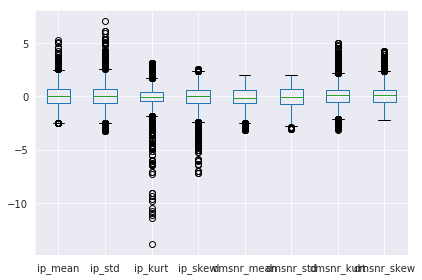

In [10]:
# use a PowerTransformer
transformer = PQTransformer(trans="power")
X_layer1_trans = pd.DataFrame(transformer.fit_transform(X_layer1),
                              columns=X_layer1.columns)
X_layer1_trans.plot(kind="box")
plt.tight_layout()

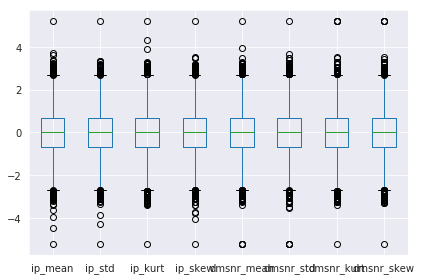

In [11]:
# use a Gaussian QuantileTransformer
transformer = PQTransformer(trans="quantile")
X_layer1_trans = pd.DataFrame(transformer.fit_transform(X_layer1),
                              columns=X_layer1.columns)
X_layer1_trans.plot(kind="box")
plt.tight_layout()

The transformed data looks as expected; after the `PowerTransformer`, the data is still on quite different scales due to the outlying values. The `QuantileTransformer` brings everything on the same range but introduced [saturation artifacts](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py) for extreme values. We'll see what works better.

Since all the 8 features come from only two types of measurements, they are most likely correlated in some way. Let's have a look at the correlation matrix.

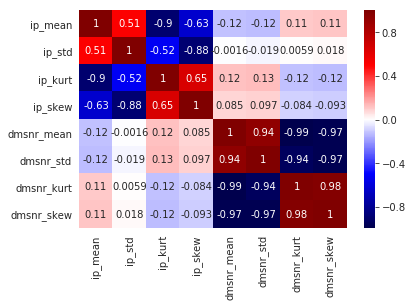

In [12]:
# plot correlation matrix
sns.heatmap(X_layer1_trans.corr(),annot=True, cmap=plt.cm.seismic)

We can try to incorporate feature interaction by adding polynomial features, treating the degree as a hyper-parameter. However we should actually create these features before we do our power/quantile transform so we'll restructure the work flow a bit.

In [13]:
# put polynomial features and Transformer into a pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
preprocess = Pipeline([
               ('poly', PolynomialFeatures()),
               ('trans', PQTransformer())])

## Selecting and tuning models
Time to train some classifiers on the data. We'll start with a simple logistic regression to get somewhat of a benchmark.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# set up a pipeline with the preprocessing and a classifier 
lr_clf = Pipeline([
               ('prep', preprocess),
               ('lr', LogisticRegression(class_weight="balanced",
                                         solver="lbfgs",
                                         random_state=1234))]) # acount for class imbalance

# perform a grid search cross evaluation of the paramters below
param_grid = {
    'prep__poly__degree': [1,2,3],
    'prep__trans__trans': ["power","quantile"],
    'lr__C': [0.01,0.1,1,10],
}

lr_grid = GridSearchCV(lr_clf, param_grid, scoring="recall",iid=False, cv=5,n_jobs=-1)
lr_grid.fit(X_layer1, y_layer1)
print("Best parameter (CV recall score=%0.3f):" % lr_grid.best_score_)
print(lr_grid.best_params_)


Best parameter (CV recall score=0.927):
{'lr__C': 1, 'prep__poly__degree': 1, 'prep__trans__trans': 'quantile'}


In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
# let's do a prediction for the layer 2 test set
y_pred = lr_grid.predict(X_layer2)
print("Logistic regression on layer 2 test set.\nConfusion matrix:")
print(confusion_matrix(y_layer2, y_pred))
print("Recall: {:0.3f}".format(recall_score(y_layer2, y_pred)))
print("Precision: {:0.3f}".format(precision_score(y_layer2, y_pred)))
print("Accuracy: {:0.3f}".format(accuracy_score(y_layer2, y_pred)))

Logistic regression on layer 2 test set.
Confusion matrix:
[[3076  176]
 [  27  301]]
Recall: 0.918
Precision: 0.631
Accuracy: 0.943


That already looks pretty okay. Since we were optimizing for recall the precision is lousy but thats probably okay - rather have humans dig through some spurious signals than missing a real one. But unfortunately we're still missing a few Pulsars (false negatives) here, so let's see if we can do better with applying ensemble methods. One of the most popular algorithms in that field is random forest. It basically is an ensemble of decision trees of which each just deals with a subset of features and a bootstrapped subset of training instances. The prediction of all these simple trees is then combined to come up with a final prediction of the whole forest. The forest can be regularized by regularizing its trees (e.g. limiting number of leave nodes or depth).

In [16]:
from sklearn.ensemble import RandomForestClassifier

# set up a pipeline with the preprocessing and a classifier 
rf_clf = Pipeline([
               ('prep', preprocess),
               ('rf', RandomForestClassifier(class_weight="balanced_subsample",
                                             random_state=1234,
                                             n_jobs=-1))]) # acount for class imbalance

# perform a grid search cross evaluation of the paramters below
param_grid = {
    'prep__poly__degree': [1,2,3],
    'prep__trans__trans': ["power","quantile"],
    'rf__n_estimators': [100,300,500],
    'rf__max_leaf_nodes': [5,10,20],
}

rf_grid = GridSearchCV(rf_clf, param_grid, scoring="recall",iid=False, cv=5,n_jobs=-1)
rf_grid.fit(X_layer1, y_layer1)
print("Best parameter (CV recall score=%0.3f):" % rf_grid.best_score_)
print(rf_grid.best_params_)

Best parameter (CV recall score=0.910):
{'prep__poly__degree': 3, 'prep__trans__trans': 'power', 'rf__max_leaf_nodes': 10, 'rf__n_estimators': 100}


In [17]:
# we reached the border of our n_estimator parameter, so lets do another grid search around that parameter
rf2_clf = Pipeline([
               ('prep', preprocess),
               ('rf', RandomForestClassifier(class_weight="balanced_subsample",
                                             random_state=1234,
                                             n_jobs=-1))]) # acount for class imbalance
param_grid = {
    'prep__poly__degree': [3],
    'prep__trans__trans': ["power"],
    'rf__n_estimators': [50,100],
    'rf__max_leaf_nodes': [4,6,10],
}

rf2_grid = GridSearchCV(rf2_clf, param_grid, scoring="recall",iid=False, cv=5,n_jobs=-1)
rf2_grid.fit(X_layer1, y_layer1)
print("Best parameter (CV recall score=%0.3f):" % rf2_grid.best_score_)
print(rf2_grid.best_params_)

Best parameter (CV recall score=0.910):
{'prep__poly__degree': 3, 'prep__trans__trans': 'power', 'rf__max_leaf_nodes': 6, 'rf__n_estimators': 100}


In [18]:
# let's do a prediction for the layer 2 test set
y_pred = rf2_grid.predict(X_layer2)
print("Random forrest on layer 2 test set.\nConfusion matrix:")
print(confusion_matrix(y_layer2, y_pred))
print("Recall: {:0.3f}".format(recall_score(y_layer2, y_pred)))
print("Precision: {:0.3f}".format(precision_score(y_layer2, y_pred)))
print("Accuracy: {:0.3f}".format(accuracy_score(y_layer2, y_pred)))

Random forrest on layer 2 test set.
Confusion matrix:
[[3181   71]
 [  33  295]]
Recall: 0.899
Precision: 0.806
Accuracy: 0.971


Looks like the forest actually performed (a little bit) worse than just the logistic regression. Maybe we can try another kind of ensemble, e.g. AdaBoost. In this ensemble, we subsequently train weak learners and each learner will try to correct the errors that its predecessor makes. We could use pretty much any base estimator, but let's stick to trees. Or rather stumps because we won't allow them to perform more than one split per estimator. 

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# set up a pipeline with the preprocessing and a classifier 
ab_clf = Pipeline([
               ('prep', preprocess),
               ('ab', AdaBoostClassifier(
                   base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         class_weight="balanced"),
                   algorithm="SAMME.R",
                   random_state=1234))]) # acount for class imbalance

# perform a grid search cross evaluation of the paramters below
param_grid = {
    'prep__poly__degree': [1,2,3],
    'prep__trans__trans': ["power","quantile"],
    'ab__n_estimators': [10,50,100],
    'ab__learning_rate': [0.5,1.0,1.5],
}

ab_grid = GridSearchCV(ab_clf, param_grid, scoring="recall",iid=False, cv=5,n_jobs=-1)
ab_grid.fit(X_layer1, y_layer1)
print("Best parameter (CV recall score=%0.3f):" % ab_grid.best_score_)
print(ab_grid.best_params_)

Best parameter (CV recall score=0.919):
{'ab__learning_rate': 0.5, 'ab__n_estimators': 10, 'prep__poly__degree': 3, 'prep__trans__trans': 'power'}


In [20]:
# we reached the border of our n_estimator parameter, so lets do another grid search around that parameter
ab2_clf = Pipeline([
               ('prep', preprocess),
               ('ab', AdaBoostClassifier(
                   base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         class_weight="balanced"),
                   algorithm="SAMME.R",
                   random_state=1234))]) # acount for class imbalance

param_grid = {
    'prep__poly__degree': [3],
    'prep__trans__trans': ["power"],
    'ab__n_estimators': [1,2,3,10],
    'ab__learning_rate': [0.1,0.3,0.5],
}

ab2_grid = GridSearchCV(ab2_clf, param_grid, scoring="recall",iid=False, cv=5,n_jobs=-1)
ab2_grid.fit(X_layer1, y_layer1)
print("Best parameter (CV recall score=%0.3f):" % ab2_grid.best_score_)
print(ab2_grid.best_params_)

Best parameter (CV recall score=0.924):
{'ab__learning_rate': 0.3, 'ab__n_estimators': 2, 'prep__poly__degree': 3, 'prep__trans__trans': 'power'}


In [21]:
# let's do a prediction for the layer 2 test set
y_pred = ab2_grid.predict(X_layer2)
print("Random forrest on layer 2 test set.\nConfusion matrix:")
print(confusion_matrix(y_layer2, y_pred))
print("Recall: {:0.3f}".format(recall_score(y_layer2, y_pred)))
print("Precision: {:0.3f}".format(precision_score(y_layer2, y_pred)))
print("Accuracy: {:0.3f}".format(accuracy_score(y_layer2, y_pred)))

Random forrest on layer 2 test set.
Confusion matrix:
[[3095  157]
 [  24  304]]
Recall: 0.927
Precision: 0.659
Accuracy: 0.949


Nice, we minimally improved the performance compared to the logistic regression. Now how about if we could stuff our ensembles into a bigger ensemble? Each of the classifiers we have trained and tuned so far can predict a probability for a class. So we could take into account all these probabilities to find out which class is considered most likely by all the classifiers combined. Scikit-Learn offers a `VotingClassifier` for this purpose.  

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import VotingClassifier
# set up the preprep pipes with the classifiers from earlier with the optimized parameters

# preprosessing + logistic regression
lr_pipe = Pipeline([('poly',PolynomialFeatures(degree=3)),
                    ('trans',PQTransformer(trans="quantile")),
                    ('lr', LogisticRegression(C=1,
                                             class_weight="balanced",
                                             solver="lbfgs",
                                             max_iter=100000,
                                             random_state=1234))])
# preprosessing + random forest
rf_pipe = Pipeline([('poly',PolynomialFeatures(degree=3)),
                    ('power',PQTransformer(trans="power")),
                    ('rf', RandomForestClassifier(n_estimators=100,
                                                  max_leaf_nodes=6,
                                                  class_weight="balanced_subsample",
                                                  random_state=1234,
                                                  n_jobs=-1))])
# preprosessing + AdaBoost
ab_pipe = Pipeline([('poly',PolynomialFeatures(degree=3)),
                    ('power',PQTransformer(trans="power")),
                    ('ab', AdaBoostClassifier(
                            base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                  class_weight="balanced"),
                            learning_rate=0.3,
                            n_estimators=2,
                            algorithm="SAMME.R",
                            random_state=1234))])


# combine everything in one voting classifier
vote_clf = VotingClassifier(estimators=[('lr', lr_pipe), ('rf', rf_pipe), ('ab', ab_pipe)],
                            voting="soft", n_jobs=-1)
_ = vote_clf.fit(X=X_layer1,y=y_layer1)

In [23]:
# let's do a prediction for the layer 2 test set
y_pred = vote_clf.predict(X_layer2)
print("Voting classifier on layer 2 test set.\nConfusion matrix:")
print(confusion_matrix(y_layer2, y_pred))
print("Recall: {:0.3f}".format(recall_score(y_layer2, y_pred)))
print("Precision: {:0.3f}".format(precision_score(y_layer2, y_pred)))
print("Accuracy: {:0.3f}".format(accuracy_score(y_layer2, y_pred)))

Voting classifier on layer 2 test set.
Confusion matrix:
[[3166   86]
 [  28  300]]
Recall: 0.915
Precision: 0.777
Accuracy: 0.968


As we can see, combining the classifiers into a voting ensemble did not improv the performance. Let's have a look at which examples are being missclassifed.

In [24]:
# train all the classifierers and get the false negatives from the prediction
lr_pipe.fit(X_layer1,y_layer1)
lr_y_pred = lr_pipe.predict(X_layer2)
lr_fn = [ i for i,x in enumerate(zip(y_layer2,lr_y_pred)) if x[0]!=x[1] and x[0]==1]

rf_pipe.fit(X_layer1,y_layer1)
rf_y_pred = rf_pipe.predict(X_layer2)
rf_fn = [ i for i,x in enumerate(zip(y_layer2,rf_y_pred)) if x[0]!=x[1] and x[0]==1]

ab_pipe.fit(X_layer1,y_layer1)
ab_y_pred = ab_pipe.predict(X_layer2)
ab_fn = [ i for i,x in enumerate(zip(y_layer2,rf_y_pred)) if x[0]!=x[1] and x[0]==1]

vote_clf.fit(X_layer1,y_layer1)
vote_y_pred = vote_clf.predict(X_layer2)
vote_fn = [ i for i,x in enumerate(zip(y_layer2,rf_y_pred)) if x[0]!=x[1] and x[0]==1]

# count how often each false negative got missclassified
print(pd.Series(lr_fn+ab_fn+rf_fn+vote_fn).value_counts())

2805    4
2960    4
2062    4
2333    4
554     4
1581    4
1590    4
2879    4
1603    4
326     4
3416    4
122     4
2234    4
134     4
244     4
140     4
2548    4
1222    4
236     4
230     4
3342    4
3061    4
3019    4
3530    4
1793    4
186     4
432     4
686     4
2141    3
3291    3
2225    3
2784    3
795     3
1846    1
2673    1
383     1
596     1
dtype: int64


Looks like almost all false negatives got missclassified by all classifiers.

We will now try to blend the output of all these classifiers into another classifer. Maybe there's a pattern in why all these false negatives get missclassified and maybe a second layer classifier will be abel to pick up this pattern and correct it.

We will use our layer 2 set to train the bleder layer but first, we'll have to send it through layer 1 (which was trained on the layer 1 set) and predict each instances class probability, which will be used as feature for layer 2. Note that when  we are ust dealing with the probability for a class, we cannot optimize for recall because one can simply categorize every instance as a Pulsar - then there would be no false negatives but a loooot of false positives and the whole task wouldn't make any sense. Therefore, we will use the F1 score, which is a mix of recall and precision. It is better suited than accuracy for strong class imbalances like in this case.

In [25]:
# we'll predict probability for the positive class using all calssifiers
def blender_features(X_layer2):
    lr_y_prob = lr_pipe.predict_proba(X_layer2)[:,1]
    rf_y_prob = rf_pipe.predict_proba(X_layer2)[:,1]
    ab_y_prob = ab_pipe.predict_proba(X_layer2)[:,1]
    vote_y_prob = vote_clf.predict_proba(X_layer2)[:,1]
# and these probabilities will be the new features for our second blender layer
    return np.c_[lr_y_prob,rf_y_prob,ab_y_prob,vote_y_prob]

In [26]:
# do a grid search on a logistic regression classifier which serves as the blender
X_blend = blender_features(X_layer2)

param_grid = {"C":[1e-10,1e-5,1e-5,1e-2,1]}
blender_grid = GridSearchCV(LogisticRegression(class_weight="balanced",
                                         solver="lbfgs",
                                         random_state=1234),
                            param_grid=param_grid, scoring="f1",
                            iid=False, cv=5,n_jobs=-1)

blender_grid.fit(X_blend,y_layer2)
print("Best parameter (CV F1 score=%0.3f):" % blender_grid.best_score_)
print(blender_grid.best_params_)

Best parameter (CV F1 score=0.839):
{'C': 1e-05}


In [27]:
# let's do a the final test prediction for the actual test set
X_blend_test = blender_features(X_test)
y_pred = blender_grid.predict(X_blend_test)
print("Blender classifier on final test set.\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Recall: {:0.3f}".format(recall_score(y_test, y_pred)))
print("Precision: {:0.3f}".format(precision_score(y_test, y_pred)))
print("Accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

Blender classifier on final test set.
Confusion matrix:
[[3167   85]
 [  30  298]]
Recall: 0.909
Precision: 0.778
Accuracy: 0.968


Okay, that's a little disappointing. Not much of an improvement here. Looks like all the fancy ensembles we tried are not performing much better than the first simple logistic regression we used as a benchmark. 

That probably means that we do not just deal with random noise that may cause trouble for some types of classifiers, and which we can try to cancel out by using ensembles. All classifiers seemed to misclassify the same instances. Probably there is something systematically different about the misclassified false negative Pulsars, something that makes them look more like the spurious signals in the data set. 

If we really wanted to solve this problem we should investigate these examples in detail now, find out what is special about them, and engineer this into features which a classification algorithm can work with in a better way. But hey, this was just supposed to be an example for demonstrating ensemble methods; hence, let's call it a day and end here.

Thanks for following me through this example!